# Session 02: Intro to the Science Pipelines Software and Data products

<br>Owner(s): **Yusra AlSayyad** ([@yalsayyad](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@yalsayyad))
<br>Last Verified to Run: **2020-05-14?**
<br>Verified Stack Release: **w_2020_19**

Now that you have brought yourself to the data via the Science Platform (Lesson 1), you can retrieve that data and rerun elements of the Science Pipelines. 

Today we'll cover:
* What are the **Science Pipelines**?
* What is this **Stack**?
* What are the **data products**?
* How to rerun an element of the pipelines, a **Task**, with a different configuration. 

We'll only quickly inspect the images and catalogs. Next week's lesson will be dedicated to learning more sophisticated methods for exploring the data.

## 1. Overview of the Science Pipelines  and the stack (presentation)

The stack is an implementation of the science pipelines and its corresponding library. 

## 2.  The Data Products

Data products include both catalogs and images.

Instead of operating directly on files and directories, we interact with on-disk data products via an abstraction layer called the data Butler. The butler operates on data repositories. DM regularly tests the science pipelines on precursor data from HSC, DECam, and simulated data generated by DESC that we call "DC2 ImSim". These Data Release Production (DRP) outputs can be found in `/datasets`. 

This notebook will be using HSC Gen 2 repo.

*Jargon Watch: Gen2/Gen3 - We're in the process of building a brand new Butler, which we are calling the 3rd Generation Butler,  or Gen3 for short.*
 
| generation | Class |
| ------------- | ------------- |
|  Gen 2  | `lsst.daf.persistence.Butler`  |
|  Gen 3   | `lsst.daf.butler.Butler` |

A Gen 2 Butler is the first stack object we are going to instantiate, with a path to a directory that is a repo.

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list lsst_distrib -s

nb-quasarpanda-w-2020-21
   19.0.0-1-gc154f85+59 	current w_2020_21 setup


In [2]:
import os
REPO = '/datasets/hsc/repo/rerun/RC/w_2020_19/DM-24822'  
from lsst.daf.persistence import Butler
butler = Butler(REPO)

In [3]:
HSC_REGISTRY_COLUMNS = ['taiObs', 'expId', 'pointing', 'dataType', 'visit', 'dateObs', 'frameId', 'filter', 'field', 'pa', 'expTime', 'ccdTemp', 'ccd', 'proposal', 'config', 'autoguider']
butler.queryMetadata('calexp', HSC_REGISTRY_COLUMNS, dataId={'filter': 'HSC-I', 'visit': 30504, 'ccd': 50})

[('2015-05-21',
  'HSCA03050400',
  1236,
  'OBJECT',
  30504,
  '2015-05-21',
  'HSCA03050512',
  'HSC-I',
  'SSP_UDEEP_COSMOS',
  0.0,
  300.0,
  -100.998,
  50,
  'o15406',
  '20140306.cfg',
  1)]

**Common error messages** when instantiating a Butler:

1) 
```PermissionError: [Errno 13] Permission denied: '/datasets/hsc/repo/rerun/RC/w_2020_19/DM-248222'```
- Translation: This directory does not exist. Confirm with  `os.path.exists(REPO)`

2) `RuntimeError: No default mapper could be established from inputs`:

- Translation: This directory exists, but is not a data repo. Does `REPO` have a file called `repositoryCfg.yaml` in it? Nope? It's not a data repo. Use `os.listdir` to see what's in your directory


*Next we'll look at 3 types of data products:*
* Images
* Catalogs: lsst.afw.table
* Catalogs: parquet/pyArrow DataFrames

## 2.1 Images

In [4]:
VISIT = 34464
CCD = 81
exposure = butler.get('calexp', visit=int(VISIT), ccd=CCD)

**Common error messages** when getting data:

1) `'HscMapper' object has no attribute 'map_calExp'`
- You're asking for a data product that doesn't exist. In this example, I asked for a 'calExp' with a capital E, which is not a thing.  Double check your spelling in: https://github.com/lsst/obs_base/blob/master/policy/exposures.yaml for images or  https://github.com/lsst/obs_base/blob/master/policy/datasets.yaml for catalogs or models.

2) `NoResults: No locations for get: datasetType:calexp dataId:DataId(initialdata={'visit': 34464, 'ccd': 105}, tag=set())`:

- This file doesn't exist. If you don't believe the Butler, add "_filename" to the data product you want, and you'll get back the filename you can lookup. For example:

        butler.get('calexp_filename', visit=VISIT, ccd=105)
        

In [5]:
butler.get('calexp_filename', visit=VISIT, ccd=105)

['/datasets/hsc/repo/rerun/RC/w_2020_19/DM-24822/01290/HSC-G/corr/CORR-0034464-105.fits']

Rare error message: Did you try that and now it says it can't find the filename? `NoResults: No locations for get: datasetType:calexp_filename dataId:DataId(initialdata={'visit': 34464, 'ccd': 81}, tag=set())` Sqlalchemy doesn't handle data types well. Force your visit or ccd numbers to be integers like `butler.get('calexp', visit=int(34464), ...`

Q: If I can get the filename from the butler, why can't I just read it in manually like I do other fits files and fits tables?

A: Because in operations, the data will not be on a shared GPFS disk like you're reading from now. We guarantee `butler.get` to work the same regardless of the backend storage. 

### Exposure Objects

The data that the butler just fetched for us is an `Exposure` object. It composes a `maskedImage` which has 3 `Image` object: an `image`, `mask`, and `variance`.  These are pointers/views!

In [6]:
exposure

In [7]:
exposure.maskedImage.image   
exposure.maskedImage.mask
exposure.maskedImage.variance

# These shortcuts work too.
exposure.image
exposure.variance
exposure.mask

# each image also has an array property e.g.
exposure.image.array

array([[10.918685 , 10.925951 , 10.933148 , ..., -3.828335 , -3.8472028,
        -3.8662384],
       [10.872785 , 10.87999  , 10.887157 , ..., -3.834874 , -3.8537395,
        -3.8727112],
       [10.826987 , 10.834162 , 10.841269 , ..., -3.84138  , -3.860182 ,
        -3.8791513],
       ...,
       [ 4.183174 ,  4.1961503,  4.2090015, ..., -1.731133 , -1.7608552,
        -1.7907059],
       [ 4.1931095,  4.2060876,  4.2189417, ..., -1.7563394, -1.7861778,
        -1.8161142],
       [ 4.203083 ,  4.216033 ,  4.228859 , ..., -1.7816143, -1.8115385,
        -1.8415605]], dtype=float32)

The exposures also include a WCS Object, a PSF Object and ExposureInfo. These can be accessed via the following methods.

In [8]:
wcs = exposure.getWcs()
psf = exposure.getPsf()
photoCalib = exposure.getPhotoCalib()
expInfo = exposure.getInfo()

In [9]:
visitInfo = expInfo.getVisitInfo()

- [x] **Exercise:** Use tab-complete or '?exposure' to explore the Exposure.  Explore details are in this visit info. What was the exposure time? What was the observation date? Exploring the other methods of Exposure object, what are the dimensions of the image?

In [10]:
?exposure

Type:           ExposureF
String form:    <lsst.afw.image.exposure.exposure.ExposureF object at 0x7febcfe55030>
File:           /opt/lsst/software/stack/stack/miniconda3-4.7.12-973126a/Linux64/afw/19.0.0-24-gf0e72354e+1/python/lsst/afw/image/exposure/exposure.so
Docstring:      <no docstring>
Init docstring:
__init__(*args, **kwargs)
Overloaded function.

1. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, width: int, height: int, wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None

2. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, dimensions: lsst.geom.Extent2I=Extent2I(0, 0), wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None

3. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, bbox: lsst.geom.Box2I, wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None

4. __init__(self: lsst.afw.image.exposure.exposure.ExposureF, maskedImage: lsst.afw.image.maskedImage.maskedImage.MaskedImageF, wcs: lsst.afw.geom.skyWcs.skyWcs.SkyWcs=None) -> None

5. __init__(s

In [11]:
# visitInfo.
# exposure.

For more documentation on Exposure objects:
* https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html

For another notebook on Exposure objects:
* https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb

Session 3 will introduce more sophisticated image display tools, and go into detail on the `Display` objects in the stack, but let's take a quick look at this image:

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import lsst.afw.display as afw_display
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (6, 4)
matplotlib.rcParams["font.size"] = 12
matplotlib.rcParams["figure.dpi"] = 120

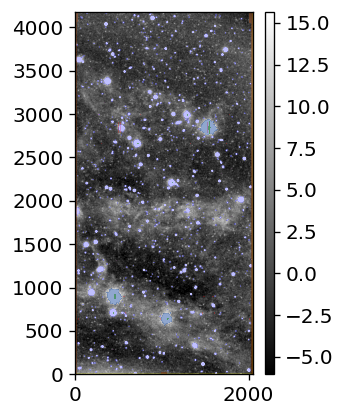

In [13]:
# Let's smooth it first just for fun. 

from skimage.filters import gaussian
exposure.image.array[:] = gaussian(exposure.image.array, sigma=5)

# and display it
display = afw_display.Display(frame=1, backend='matplotlib')
display.scale("linear", "zscale")
display.mtv(exposure)

From the colorbar, you can tell that the background has been subtracted.

The first step of the pipeline, `processCcd` takes a `postISRCCD` as input. Before detection and measurement, it estimates a naive background and subtracts it.  Indeed we store a `calexp` with the background subtracted and model that was subtracted from the original `postISRCCD` as the `calexpBackground`.

*Jargon Watch: ISR - Instrument Signature Removal (ISR) encapsulates all the steps you normally associated with reducing astronomical imaging data (bias subtraction, flat fielding, crosstalk correction, cosmic ray removal, etc.)*


There's full focal plane background estimation step that produces a delta on the `calexpBackground`, which is called `skyCorr`. 

Let's quickly plot these:

Text(0.5, 1.0, 'SkyCorr Bkgd')

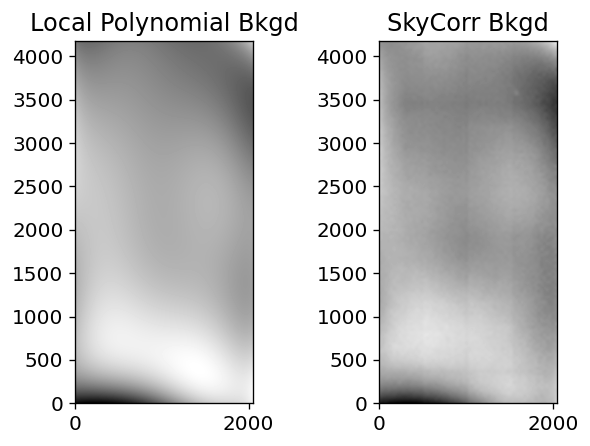

In [14]:
# Fetch background models from the butler
background = butler.get('calexpBackground', visit=VISIT, ccd=CCD)
skyCorr = butler.get('skyCorr', visit=VISIT, ccd=CCD)

# call "getImage" to evaluate the model on a pixel grid
plt.subplot(121)
plt.imshow(background.getImage().array, origin='lower', cmap='gray')
plt.title("Local Polynomial Bkgd")
plt.subplot(122)
plt.imshow(background.getImage().array - skyCorr.getImage().array, origin='lower', cmap='gray')
plt.title("SkyCorr Bkgd")

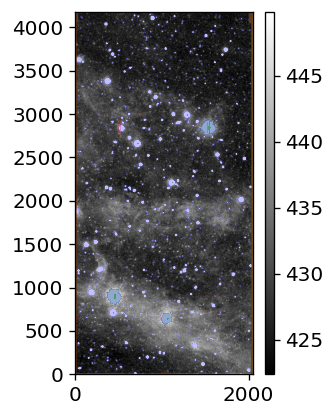

In [15]:
exposure = butler.get('calexp', visit=VISIT, ccd=CCD)
background = butler.get('calexpBackground', visit=VISIT, ccd=CCD)
# create a view to the masked image
mi = exposure.maskedImage
# add the background image to that view.
mi += background.getImage()

display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("linear", "zscale")
exposure.image.array[:] = gaussian(exposure.image.array, sigma=5)
display1.mtv(exposure)

It is good to get in the habit of mathmatical operations on maskedImages instead of images, because it scales the variance plane appropriately. For example, when you multiply a `MaskedImage` by 2, it multiplies the `Image` by 2 and the `Variance` by 4.

**Exercise 2.1)** Coadds have dataId's defined by their SkyMap. Fetch the `deepCoadd` with `tract=9813`, `patch='3,3'` and `filter='HSC-I'` from the same repo. 

Bonus: a `deepCoadd_calexp` has had an additional aggressive background model applied called a `deepCoadd_calexp_background`. Confirm that the `deepCoadd_calexp` + `deepCoadd_calexp_background` = `deepCoadd`

In [16]:
deepCoadd = butler.get('deepCoadd', tract=9813, patch='3,3', filter='HSC-I')
deepCoadd_calexp_background = butler.get('deepCoadd_calexp_background', tract=9813, patch='3,3', filter='HSC-I')
deepCoadd_calexp = butler.get('deepCoadd_calexp', tract=9813, patch='3,3', filter='HSC-I')

In [17]:
mi = deepCoadd_calexp.maskedImage
mi += deepCoadd_calexp_background.getImage()

deepCoadd.image.array - deepCoadd_calexp.image.array


array([[ 0.0000000e+00,  0.0000000e+00,  9.3132257e-10, ...,
         9.3132257e-10,  0.0000000e+00, -2.3283064e-10],
       [ 0.0000000e+00,  2.3283064e-10,  0.0000000e+00, ...,
         9.3132257e-10,  1.8626451e-09,  0.0000000e+00],
       [ 1.8626451e-09, -9.3132257e-10,  0.0000000e+00, ...,
         0.0000000e+00,  1.8626451e-09,  3.7252903e-09],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  3.7252903e-09],
       [ 9.3132257e-10,  3.7252903e-09, -4.0745363e-10, ...,
        -9.3132257e-10,  0.0000000e+00,  0.0000000e+00],
       [-4.6566129e-10, -9.3132257e-10, -1.1641532e-10, ...,
         0.0000000e+00,  4.6566129e-10, -3.4924597e-10]], dtype=float32)

## 2.2 Catalogs (lsst.afw.table format)


afwTables are for passing to tasks.  The pipeline needed C++ readable table format, so we wrote one. If you want to pass a catalog to a Task, it'll probably take one of these. They are:
* Row stores and
* the column names are oriented for software

The source table immediatly output by processCcd is called `src`

In [18]:
src = butler.get('src', visit=VISIT, ccd=CCD)
src

<class 'lsst.afw.table.SourceCatalog'>
        id             coord_ra      ... calib_photometry_reserved
                         rad         ...                          
----------------- ------------------ ... -------------------------
29604698470219777  5.884632492879257 ...                     False
29604698470219778  5.884639532871275 ...                     False
29604698470219779  5.884642594479254 ...                     False
29604698470219780 5.8846542714413586 ...                     False
29604698470219781  5.884654483671514 ...                     False
29604698470219782  5.884669996845061 ...                     False
29604698470219783  5.884658729833988 ...                     False
29604698470219784  5.884658778424009 ...                     False
29604698470219785  5.884661830443291 ...                     False
29604698470219786  5.884664109592766 ...                     False
              ...                ... ...                       ...
29604698470220670  5.88

The returned object, `src`, is a `lsst.afw.table.SourceCatalog` object. 

In [19]:
src.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psf_candidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Fiel

Inspecting the schema reveals that instFluxes are in uncalibrated units of counts. coord_ra/coord_dec are in units of radians. 

`lsst.afw.table.SourceCatalog`s have their own API. However if you are *just* going to use it for analysis, you can convert it to an AstroPy table or a pandas DataFrame:

In [20]:
src.asAstropy()

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,sky_source,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_

In [21]:
df = src.asAstropy().to_pandas()
df.tail()

,id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,...,slot_PsfFlux_flag_apCorr,ext_photometryKron_KronFlux_apCorr,ext_photometryKron_KronFlux_apCorrErr,ext_photometryKron_KronFlux_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,calib_astrometry_used,calib_photometry_used,calib_photometry_reserved
898,29604698470220675,5.887957,0.038391,29604698470220412,False,False,False,False,0,True,...,False,1.012235,0.0,False,0.0,False,554,False,False,False
899,29604698470220676,5.887964,0.038922,29604698470220414,False,False,False,False,0,False,...,False,1.008436,0.0,False,1.0,False,353,False,False,False
900,29604698470220677,5.887966,0.038914,29604698470220414,False,False,False,False,0,False,...,False,1.008463,0.0,False,0.0,False,77,False,False,False
901,29604698470220678,5.887980,0.039030,29604698470220419,False,False,False,False,0,True,...,False,1.008045,0.0,False,1.0,False,748,False,False,False
902,29604698470220679,5.887990,0.039038,29604698470220419,False,False,False,False,0,True,...,False,1.007992,0.0,False,1.0,False,648,False,False,False


## 2.3 Catalogs (Parquet/PyArrow DataFrame format)

* Output data product ready for analysis
* Column store
* Full visit and full tract options
* Column names

The parquet outputs have been transformed to database-specified units. Fluxes are in nanojanskys, coordinates are in degrees. These will match what you get via the Portal and the Catalog Access tool Simon showed last week.

**NOTE:** The `sourceTable` is a relatively new edition to the Stack, and probably requires a stack version more recent than v19.


In [22]:
parq = butler.get('sourceTable', visit=VISIT, ccd=CCD)

The `ParquetTable` is just a light  wrapper around a `pyarrow.parquet.ParquetFile`.

You can get a parquet table from the butler, but it doesn't fetch any columns until you ask for them. It's a column store which means that it can read only one column at a time. This is great for analysis when you want to plot two million element arrays. In a row-store you'd have to read the whole ten million-row table just for those two columns you wanted. 

But don't even try to loop through rows! If you want a whole row, use the `afwTable`. 

Last I checked the processing step that consolidates the Source Tables from a per-ccd Source Table to a 

`parq = butler.get('sourceTable', visit=VISIT)`

In [23]:
parq

In [24]:
# inspect the columns with: 
parq.columns

['sourceId',
 'coord_ra',
 'coord_dec',
 'ccdVisitId',
 'parentSourceId',
 'x',
 'y',
 'xErr',
 'yErr',
 'ra',
 'decl',
 'ApFlux',
 'ApFluxErr',
 'sky',
 'skyErr',
 'PsFlux',
 'PsFluxErr',
 'Ixx',
 'Iyy',
 'Ixy',
 'IxxPsf',
 'IyyPsf',
 'IxyPsf',
 'extendedness',
 'LocalPhotoCalib',
 'LocalPhotoCalib_flag',
 'LocalPhotoCalibErr',
 'LocalWcs_flag',
 'LocalWcs_CDMatrix_2_1',
 'LocalWcs_CDMatrix_1_1',
 'LocalWcs_CDMatrix_1_2',
 'LocalWcs_CDMatrix_2_2',
 'Blendedness_abs',
 'Blendedness_flag',
 'Blendedness_flag_noCentroid',
 'Blendedness_flag_noShape',
 'ApFlux_12_0_flag',
 'ApFlux_12_0_flag_apertureTruncated',
 'ApFlux_12_0_flag_sincCoeffsTruncated',
 'ApFlux_12_0_instFlux',
 'ApFlux_12_0_instFluxErr',
 'ApFlux_17_0_flag',
 'ApFlux_17_0_flag_apertureTruncated',
 'ApFlux_17_0_instFlux',
 'ApFlux_17_0_instFluxErr',
 'ApFlux_25_0_flag',
 'ApFlux_25_0_flag_apertureTruncated',
 'ApFlux_25_0_instFlux',
 'ApFlux_25_0_instFluxErr',
 'ApFlux_35_0_flag',
 'ApFlux_35_0_flag_apertureTruncated',
 'ApF

Note that the column names are different. Now fetch just the columns you want. For example:

In [25]:
df = parq.toDataFrame(columns=['ra', 'decl', 'PsFlux', 'PsFluxErr', 'sky_source',
                               'PixelFlags_bad', 'PixelFlags_sat', 'PixelFlags_saturated'])

**Exercise:** Using this DataFrame `df`, make a histogram of `PsFlux` for sky sources using this parquet source table. If `sky_source == True` then the source was not a normal detection, but rather an randomly placed centroid to measure properties of blank sky. The distribution should be centered at 0. 


**Exercise:** A parquet `objectTable_tract` contains deep coadd measurements for 1.5 sq. deg. tract.
**Make a r-i vs. g-r plot** of stars with a r-band SNR > 100. Use `refExtendedness` == 0 to select for stars. It means that the galaxy model Flux was similar to the PSF Flux. By the looks of your plot, what do you think about using refExtendedness for star galaxy separation?*


In [26]:
# butler = Butler('/datasets/hsc/repo/rerun/DM-23243/OBJECT/DEEP')
# parq = butler.get('objectTable_tract', tract=9813)
# parq.columns

# Tasks


**TL;DR  If you remember one thing about tasks it's go to http://pipelines.lsst.io, then click on lsst.pipe.base**

On the landing page for lsst.pipe.base documenation https://pipelines.lsst.io/modules/lsst.pipe.base/index.html, you'll see a number of tutorials on how to use Tasks and how to create one.

CmdlineTask extends Task with commandline driver utils for use with Gen2 Butlers, and will be deprecated soon. However, not all the links under "CommandlineTask" will become obsolete. For example, Retargeting subtasks of command-line tasks will live on.

Read: https://pipelines.lsst.io/modules/lsst.pipe.base/task-framework-overview.html

What is a Task?
Tasks implement astronomical data processing functionality. They are:

* **Configurable:** Modify a task’s behavior by changing its configuration. Automatically apply camera-specific modifications
* **Hierarchical:** Tasks can call other tasks as subtasks
* **Extensible:** Replace (“retarget”) any subtask with a variant. Write your own subclass of a task.


In [27]:
# Edited highlights of ${PIPE_TASKS_DIR}/example/exampleStatsTask.py
import sys
import numpy as np
from lsst.geom import Box2I, Point2I, Extent2I
from lsst.afw.image import MaskedImageF
from lsst.pipe.tasks.exampleStatsTasks import ExampleSimpleStatsTask, ExampleSigmaClippedStatsTask

In [28]:
# Load a MaskedImageF -- an image containing floats
# together with a mask and a per-pixel variance.

WIDTH = 40
HEIGHT = 20

maskedImage = MaskedImageF(Box2I(Point2I(10, 20),
                                 Extent2I(WIDTH, HEIGHT)))
x = np.random.normal(10, 20, size=WIDTH*HEIGHT)

# Because we are shoving it into an ImageF and numpy defaults
# to double precision
X = x.reshape(HEIGHT, WIDTH).astype(np.float32)  
im = maskedImage.image
im.array = X

# We initialize the Task once but can call it many times.
task = ExampleSimpleStatsTask()

# Simply call the .run() method with the MaskedImageF.
# Most Tasks have a .run() method. Look there first. 
result = task.run(maskedImage)

# And print the result.
print(result)

Struct(mean=10.747188781565054; meanErr=0.7108371746222903; stdDev=20.1055114597963; stdDevErr=0.5023235396455004)


## Using a Task with configuration

Now we are going to instantiate Tasks with two different configs. Configs must be set *before* instantiating the task. Do not change the config of an already-instatiated Task object. It will not do what you think it's doing. 

In fact, during commandline processing, the `Task` drivers such as `CmdLineTask` freeze the configs before running the Task. When you're running them from notebooks, they are not frozen, hence this warning.

In [29]:
# Edited highlights of ${PIPE_TASKS_DIR}/example/exampleStatsTask.py

config1 = ExampleSigmaClippedStatsTask.ConfigClass(numSigmaClip=1)

config2 = ExampleSigmaClippedStatsTask.ConfigClass()
config2.numSigmaClip = 3

task1 = ExampleSigmaClippedStatsTask(config=config1)
task2 = ExampleSigmaClippedStatsTask(config=config2)

print(task1.run(maskedImage).mean)
print(task2.run(maskedImage).mean)


# Example of what not to do
# -------------------------
# task1 = ExampleSigmaClippedStatsTask(config=config1)
# print(task1.run(maskedImage).mean)
# DO NOT EVER DO THIS!
# task1.config.numSigmaClip = 3  <--- bad bad bad 
# print(task1.run(maskedImage).mean)

10.687153584309756
10.822356706360981


## Background Subtraction and Task Configuration

The following example of reconfiguring a task is one step in an introduction to `processCcd`: https://github.com/lsst-sqre/notebook-demo/blob/master/AAS_2019_tutorial/intro-process-ccd.ipynb

`processCcd`, our basic source extractor run as the first step step in the pipeline, will be covered in more detail in Session 4. 

In [30]:
from lsst.meas.algorithms import SubtractBackgroundTask

In [31]:
# Add the background back in so that we can remodel it (like we did above)

postISRCCD  = butler.get("calexp", visit=30502, ccd=CCD)
bkgd = butler.get("calexpBackground", visit=30502, ccd=CCD)
mi = exposure.maskedImage
mi += bkgd.getImage()

In [32]:
# Execute this cell to get fun & terrible results!
bkgConfig = SubtractBackgroundTask.ConfigClass()
bkgConfig.useApprox = False
bkgConfig.binSize = 20

 The `config` object here is an instance of a class that inherits from `lsst.pex.config.Config` that contains a set of `lsst.pex.config.Field` objects that define the options that can be modified.  Each `Field` behaves more or less like a Python `property`, and you can get information on all of the fields in a config object by either using `help`:

In [33]:
help(bkgConfig)

Help on SubtractBackgroundConfig in module lsst.meas.algorithms.subtractBackground object:

class SubtractBackgroundConfig(lsst.pex.config.config.Config)
 |  SubtractBackgroundConfig(*args, **kw)
 |  
 |  !Config for SubtractBackgroundTask
 |  
 |  @note Many of these fields match fields in lsst.afw.math.BackgroundControl,
 |  the control class for lsst.afw.math.makeBackground
 |  
 |  Method resolution order:
 |      SubtractBackgroundConfig
 |      lsst.pex.config.config.Config
 |      builtins.object
 |  
 |  Data descriptors defined here:
 |  
 |  statisticsProperty
 |      type of statistic to use for grid points (`str`, default ``'MEANCLIP'``)
 |      
 |      Allowed values:
 |      
 |      ``'MEANCLIP'``
 |        clipped mean
 |      ``'MEAN'``
 |        unclipped mean
 |      ``'MEDIAN'``
 |        median
 |      ``'None'``
 |        Field is optional
 |  
 |  undersampleStyle
 |      behaviour if there are too few points in grid for requested interpolation style (`str`, def

In [34]:
SubtractBackgroundTask.ConfigClass.algorithm?

Type:            ChoiceField
String form:     <lsst.pex.config.choiceField.ChoiceField object at 0x7febd2d8f6d0>
File:            /opt/lsst/software/stack/stack/miniconda3-4.7.12-973126a/Linux64/pex_config/19.0.0-11-g48a0200+2/python/lsst/pex/config/choiceField.py
Docstring:      
how to interpolate the background values. This maps to an enum; see afw::math::Background (`str`, default ``'AKIMA_SPLINE'``)

Allowed values:

``'CONSTANT'``
  Use a single constant value
``'LINEAR'``
  Use linear interpolation
``'NATURAL_SPLINE'``
  cubic spline with zero second derivative at endpoints
``'AKIMA_SPLINE'``
  higher-level nonlinear spline that is more robust to outliers
``'NONE'``
  No background estimation is to be attempted
``'None'``
  Field is optional
Class docstring:
A configuration field (`~lsst.pex.config.Field` subclass) that allows a
user to select from a predefined set of values.

Use ``ChoiceField`` when a configuration can only take one of a predefined
set of values. Each choice m

In [35]:
bkgTask = SubtractBackgroundTask(config=bkgConfig)

In [36]:
bkgResult = bkgTask.run(exposure)

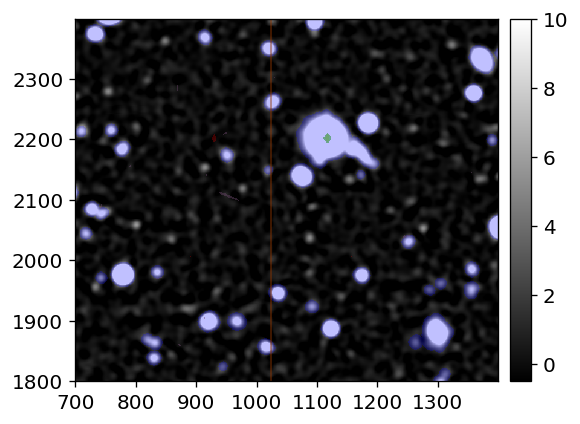

In [37]:
display1 = afw_display.Display(frame=1, backend='matplotlib')
display1.scale("linear", min=-0.5, max=10)
display1.mtv(exposure[700:1400,1800:2400])

If you've run through all of these steps after executing the cell that warns about terrible results, you should notice that the galaxy in the upper right has been oversubtracted.

**Exercise**: Before continuing on, re-load the exposure from disk, reset the configuration and `Task` instances, and re-run without executing the cell that applies bad values to the config, all by just re-executing the right cells above.  You should end up an image in which the upper-right galaxy looks essentially the same as it does in the image before we subtracted the background.